In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
raw_data = pd.read_pickle('predictors/securities.pkl')
target_df = (pd.read_excel('RESPONSE Main 1m.xls', skiprows=range(6))
               .rename(columns=lambda x: x.strip())
               .assign(**{'Effective date': lambda df: pd.to_datetime(df['Effective date'], errors='coerce')})
               .dropna(subset=['Effective date'])
               .set_index('Effective date'))

In [4]:
raw_data

0GGH Bonds Global_price  0GGH Bonds Global_volume  \
Date                                                            
2019-05-03                    5.035                  124760.0   
2019-05-06                      NaN                       NaN   
2019-05-07                    5.048                  183200.0   
2019-05-08                    5.048                  183140.0   
2019-05-09                    5.045                   61310.0   
...                             ...                       ...   
2024-05-03                    4.668                    6110.0   
2024-05-06                    4.678                     620.0   
2024-05-07                    4.692                  107410.0   
2024-05-08                    4.676                    3140.0   
2024-05-09                    4.680                    3450.0   

            EUNK Equities Europe_price  EUNK Equities Europe_volume  \
Date                                                                  
2019-05-03                       52.19                      36390.0   
2019-05-06                       51.61                       5530.0   
2019-05-07                       50.98                      11130.0   
2019-05-08                       51.02                     129110.0   
2019-05-09                       50.30                       5250.0   
...                                ...                          ...   
2024-05-03                       77.08                      30170.0   
2024-05-06                       77.60                      29960.0   
2024-05-07                       78.44                      46950.0   
2024-05-08                       78.68                      15760.0   
2024-05-09                       79.01                       8560.0   

            Euribor c2 Futures Historical Data_price  \
Date                                                   
2019-05-03                                    100.31   
2019-05-06                                    100.31   
2019-05-07                                    100.31   
2019-05-08                                    100.31   
2019-05-09                                    100.31   
...                                              ...   
2024-05-03                                     96.30   
2024-05-06                                       NaN   
2024-05-07                                     96.30   
2024-05-08                                     96.29   
2024-05-09                                       NaN   

            Euribor c2 Futures Historical Data_volume  \
Date                                                    
2019-05-03                                    20270.0   
2019-05-06                                    11410.0   
2019-05-07                                    16220.0   
2019-05-08                                    15630.0   
2019-05-09                                    12290.0   
...                                               ...   
2024-05-03                                   186530.0   
2024-05-06                                        NaN   
2024-05-07                                    70370.0   
2024-05-08                                    93770.0   
2024-05-09                                        NaN   

            IEAC Bonds Europe_price  IEAC Bonds Europe_volume  \
Date                                                            
2019-05-03                   132.06                   71250.0   
2019-05-06                      NaN                       NaN   
2019-05-07                   132.02                 1800000.0   
2019-05-08                   131.84                   16340.0   
2019-05-09                   131.51                   11540.0   
...                             ...                       ...   
2024-05-03                   118.28                   56710.0   
2024-05-06                      NaN                       NaN   
2024-05-07                      NaN                       NaN   
2024-05-08                      NaN                     

In [5]:
# handling extreme values
data_df = raw_data.apply(lambda x: pd.to_numeric(x, errors='coerce')).apply(lambda x: x.where(x <= 1.4 * x.shift(1))).ffill()

# scaling volume
min_max_scaler = MinMaxScaler()
volume_columns = ['ISSUSW Equities Global_volume', 'Euribor c2 Futures Historical Data_volume', 'IEAC Bonds Europe_volume', 'EUNK Equities Europe_volume', '0GGH Bonds Global_volume', 'XTC5 iTraxx Cross_volume']
volume = data_df[volume_columns]
volume_normalized = min_max_scaler.fit_transform(volume)
data_df[volume_columns] = volume_normalized

# taking diff in logs
adjusted_data_df = data_df + 0.000001
ln_rates = np.log(adjusted_data_df / adjusted_data_df.shift(1)).dropna()
ln_rates = (ln_rates - ln_rates.mean()) / ln_rates.std()
ln_rates.columns = [col + '_rates' for col in ln_rates.columns]

In [6]:
sigma = ln_rates.rolling(window=30).std()

sigma.columns = [col.replace('_rates', '_volatility').replace('_prices', '_volatility') 
                 if '_rates' in col or '_prices' in col 
                 else col + '_volatility' for col in sigma.columns]

#### aggregaring covariates

In [8]:
all_features = pd.concat([data_df, sigma, ln_rates], axis=1)

#### Feature Selection

In [9]:
Y = target_df['ITraxx/Cboe Europe Main 1-Month Volatility Index (BP Volatility)'].shift(-1)
X = all_features.iloc[:-1, :]

Y = Y.dropna()
X = X[X.index.isin(Y.index)]

valid_start, valid_end = X.apply(lambda col: col.first_valid_index()).max(), X.apply(lambda col: col.last_valid_index()).min()

X_trimmed = X.loc[valid_start:valid_end].iloc[:-50]

# align
Y_trimmed = Y.reindex(X_trimmed.index)

                                              Feature  Importance
4            Euribor c2 Futures Historical Data_price    0.274466
8                        ISSUSW Equities Global_price    0.175092
10                          TCRS Term Structure_price    0.146160
26                 XTC5 iTraxx Cross_price_volatility    0.066637
20                 IEAC Bonds Europe_price_volatility    0.064175
2                          EUNK Equities Europe_price    0.059971
11                         VSTOXX 50 Volatility_price    0.047740
24               TCRS Term Structure_price_volatility    0.031583
12                            XTC5 iTraxx Cross_price    0.028645
18  Euribor c2 Futures Historical Data_price_volat...    0.020610
0                             0GGH Bonds Global_price    0.009343
21                IEAC Bonds Europe_volume_volatility    0.009314
6                             IEAC Bonds Europe_price    0.006719
14                 0GGH Bonds Global_price_volatility    0.005128
16        

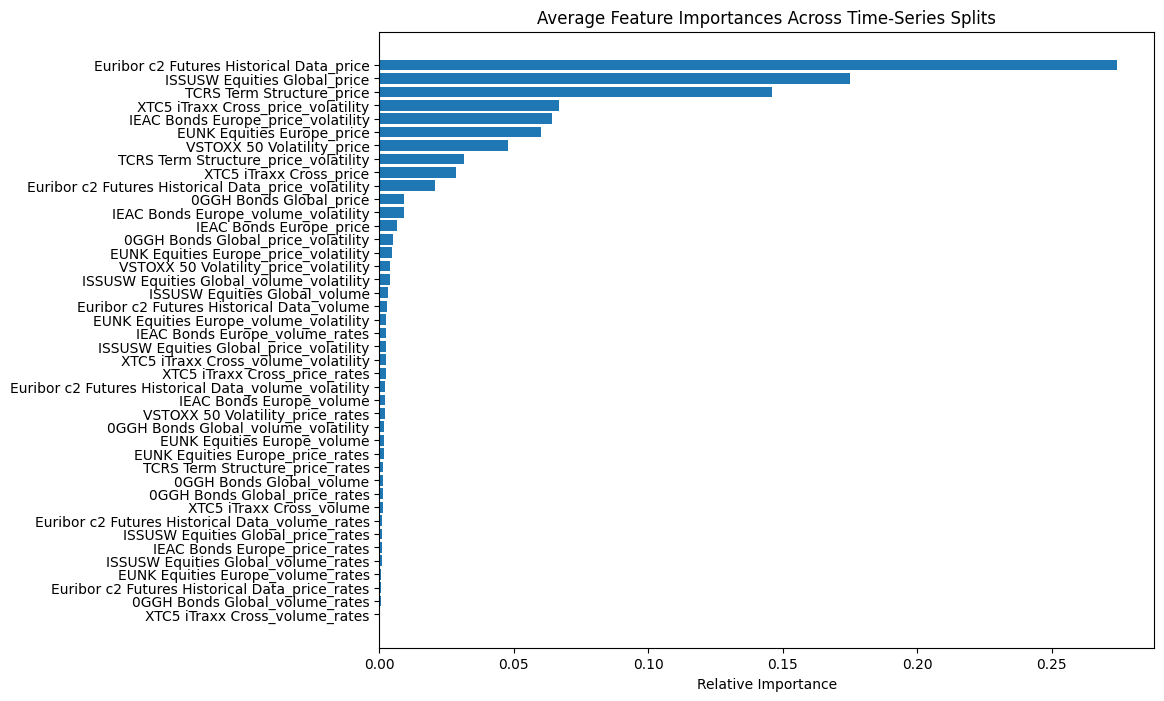

In [10]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
feature_importances = np.zeros((n_splits, X_trimmed.shape[1]))

# train/test splits
for i, (train_index, test_index) in enumerate(tscv.split(X_trimmed)):
    X_train, X_test = X_trimmed.iloc[train_index], X_trimmed.iloc[test_index]
    Y_train, Y_test = Y_trimmed.iloc[train_index], Y_trimmed.iloc[test_index]
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, Y_train)
    feature_importances[i, :] = rf_model.feature_importances_

average_importances = feature_importances.mean(axis=0)
feature_names = X_trimmed.columns
 # rank features
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': average_importances
}).sort_values(by='Importance', ascending=False)

# select the top 20 features
top_features = importance_df.head(20)
selected_features = X_trimmed[top_features['Feature']]

print(importance_df)
plt.figure(figsize=(10, 8))
plt.title('Average Feature Importances Across Time-Series Splits')
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.show()

In [11]:
selected_features.to_pickle('features.pkl')

db x-trackers II iTraxx Crossover 5y Short UCITS (XTC5)

Think about modelling the term structure, premias, relationships etc. perhaps euro / global also, and a merton model proxy. Could even take the difference in corp and govvies to remove risks.